In [474]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss

In [96]:
# using the augmented dicky fuller test 
def adfuller_test(series) : 
     result = adfuller(series)
     print('ADF Statistic: %f' % result[0]) # the more negative this value is the more likely ts is stationary
     print('p-value: %f' % result[1])       # if p-values is less than 0.05 we reject the null: ts is non-stationary
     print('Critical Values:')
     for key, value in result[4].items():
          print('\t%s: %.3f' % (key, value))
     print(f'Result: The series is {"not " if result[1] > 0.05 else ""}stationary')

def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

# Load the Data

In [323]:
gafa_stock = pd.read_csv('C:/Users/nickc/DataScience/NickAMC.github.io/DATA_624_S24/rdata/gafa_stock.csv', parse_dates=True, index_col = 'Date')

In [325]:
google = gafa_stock.query('Symbol == "GOOG"')[['Open']]

In [575]:
expected_range = pd.date_range(start = google.index.min(), end = google.index.max())

missing_dates = expected_range.difference(google.index)

if missing_dates.empty:
    print("No missing dates found in the time series.")
else:
    print("Missing dates:")
    print(missing_dates)
    print("Number of Missing Dates: ", len(missing_dates))

Missing dates:
DatetimeIndex(['2014-01-04', '2014-01-05', '2014-01-11', '2014-01-12',
               '2014-01-18', '2014-01-19', '2014-01-20', '2014-01-25',
               '2014-01-26', '2014-02-01',
               ...
               '2018-12-05', '2018-12-08', '2018-12-09', '2018-12-15',
               '2018-12-16', '2018-12-22', '2018-12-23', '2018-12-25',
               '2018-12-29', '2018-12-30'],
              dtype='datetime64[ns]', length=567, freq=None)
Number of Missing Dates:  567


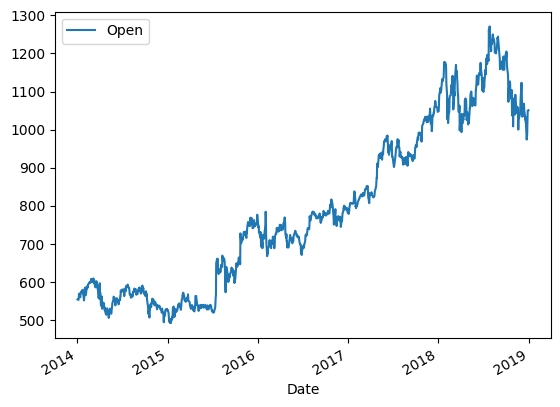

In [326]:
google.plot()
plt.show()

In [327]:
display(adfuller_test(google))
display(kpss_test(google))

ADF Statistic: -0.642239
p-value: 0.861149
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Result: The series is not stationary


None

KPSS Statistic: 5.449810701097353
p-value: 0.01
num lags: 21
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary


C:\Users\nickc\AppData\Local\Temp\ipykernel_48852\2851492813.py:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(series, **kw)


None

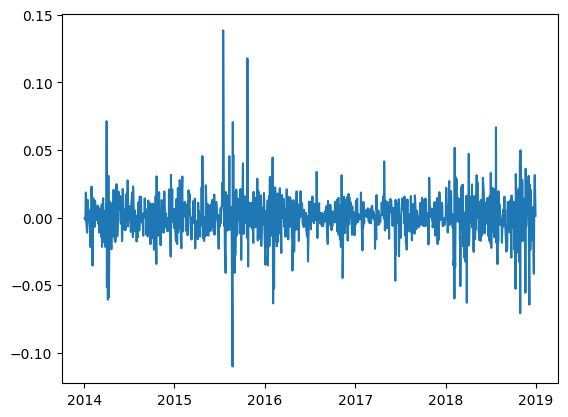

In [576]:
google_log = np.log(google)
google_log_diff = google_log.diff().dropna()
plt.plot(google_log_diff)
plt.show()

In [577]:
print(adfuller_test(google_log_diff))
print(kpss_test(google_log_diff))

ADF Statistic: -12.555178
p-value: 0.000000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Result: The series is stationary
None
KPSS Statistic: 0.05074181530790068
p-value: 0.1
num lags: 9
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary
None


C:\Users\nickc\AppData\Local\Temp\ipykernel_48852\2851492813.py:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(series, **kw)


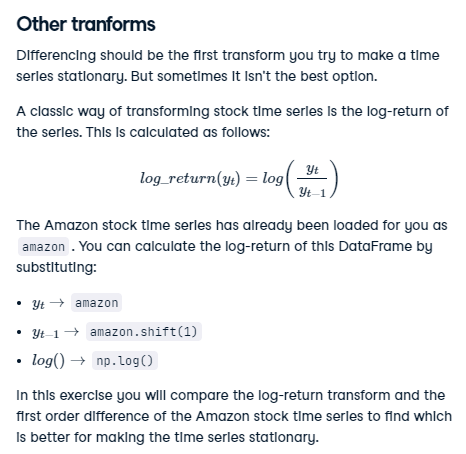

# FInd the Best Parameters for the ARIMA Models

In [461]:
order_aic_bic = []

for p in range(3) :
     for q in range(3) :
          model = ARIMA(google_log_diff, order = (p,1,q)) # we know 1 order of differencing is needed
          results = model.fit()

          order_aic_bic.append((p,q, results.aic, results.bic))
          


c:\Users\nickc\DataScience\ds_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\nickc\DataScience\ds_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\nickc\DataScience\ds_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\nickc\DataScience\ds_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.

In [581]:
# Construct DataFrame from order_aic_bic
order_df = pd.DataFrame(order_aic_bic, 
                        columns=['p','q','AIC','BIC'])

# Print order_df in order of increasing AIC
print(order_df.sort_values('AIC'))

print('*********************************')
# Print order_df in order of increasing BIC
print(order_df.sort_values('BIC'))

   p  q          AIC          BIC
4  1  1 -6869.548139 -6854.141077
2  0  2 -6869.263324 -6853.856262
7  2  1 -6867.780348 -6847.237599
8  2  2 -6865.552180 -6839.873743
1  0  1 -6863.592638 -6853.321263
5  1  2 -6861.327671 -6840.784922
6  2  0 -6524.990899 -6509.583836
3  1  0 -6348.681696 -6338.410321
0  0  0 -5905.336192 -5900.200505
*********************************
   p  q          AIC          BIC
4  1  1 -6869.548139 -6854.141077
2  0  2 -6869.263324 -6853.856262
1  0  1 -6863.592638 -6853.321263
7  2  1 -6867.780348 -6847.237599
5  1  2 -6861.327671 -6840.784922
8  2  2 -6865.552180 -6839.873743
6  2  0 -6524.990899 -6509.583836
3  1  0 -6348.681696 -6338.410321
0  0  0 -5905.336192 -5900.200505


In [582]:
model = ARIMA(google_log, order = (1,1,1))

result = model.fit()
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                   Open   No. Observations:                 1258
Model:                 ARIMA(1, 1, 1)   Log Likelihood                3443.965
Date:                Mon, 26 Feb 2024   AIC                          -6881.930
Time:                        18:54:47   BIC                          -6866.520
Sample:                             0   HQIC                         -6876.138
                               - 1258                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1899      0.258     -0.735      0.462      -0.696       0.316
ma.L1          0.1116      0.259      0.431      0.666      -0.396       0.619
sigma2         0.0002    3.8e-06     64.219      0.0

c:\Users\nickc\DataScience\ds_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


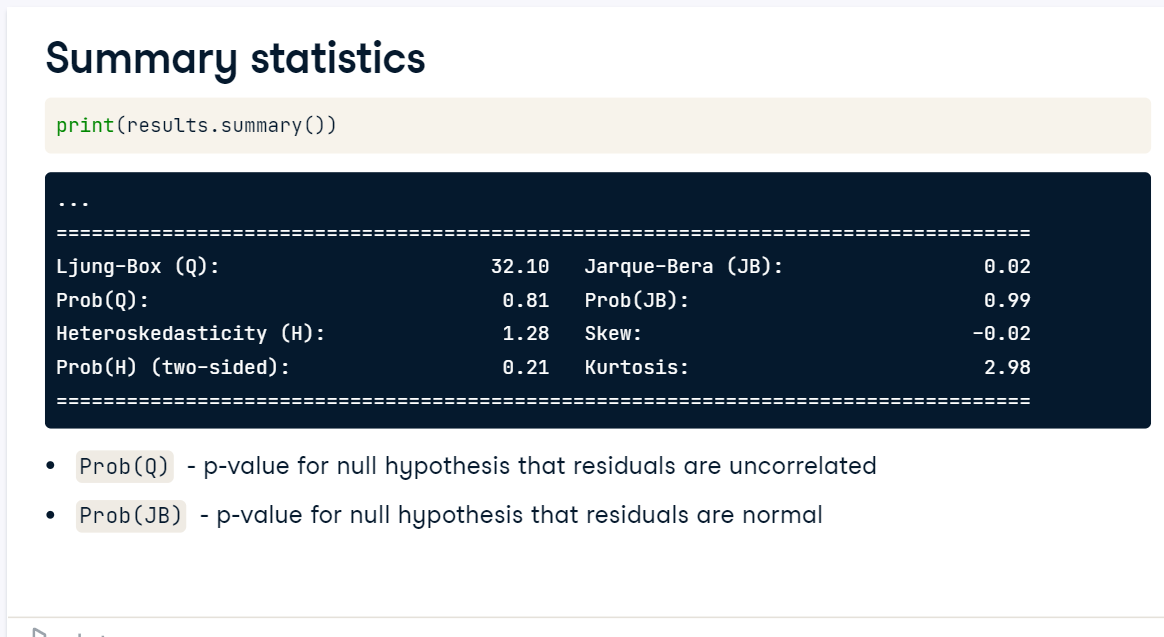

# Residual Analysis

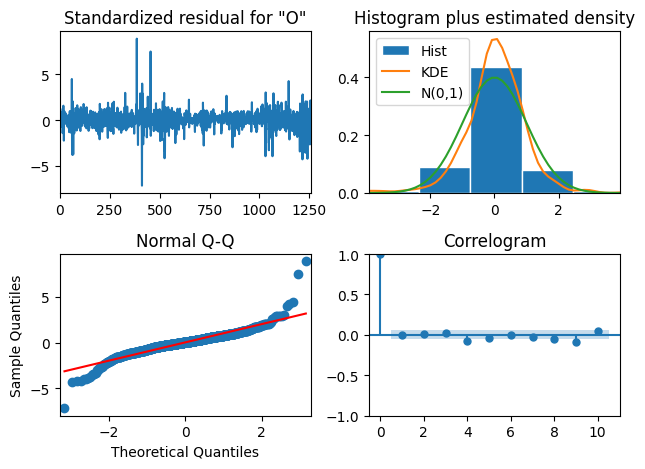

In [583]:
result.plot_diagnostics()
plt.tight_layout()
plt.show()

In [584]:
mae = np.mean(np.abs(result.resid))

print(f'MAE: {mae}')

MAE: 0.01564654735555415


# AUTO ARIMA

In [549]:
from pmdarima import plot_acf

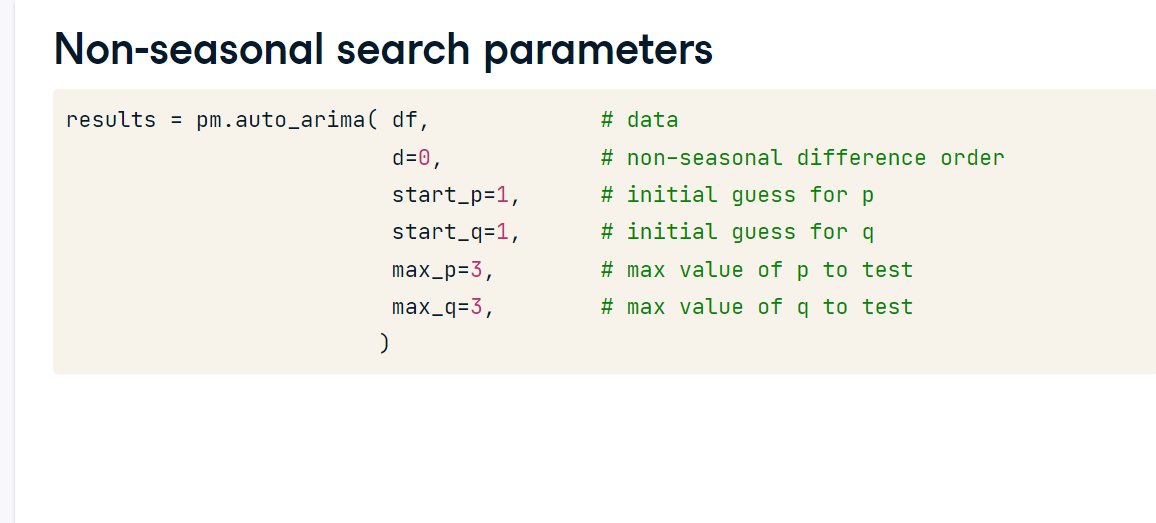

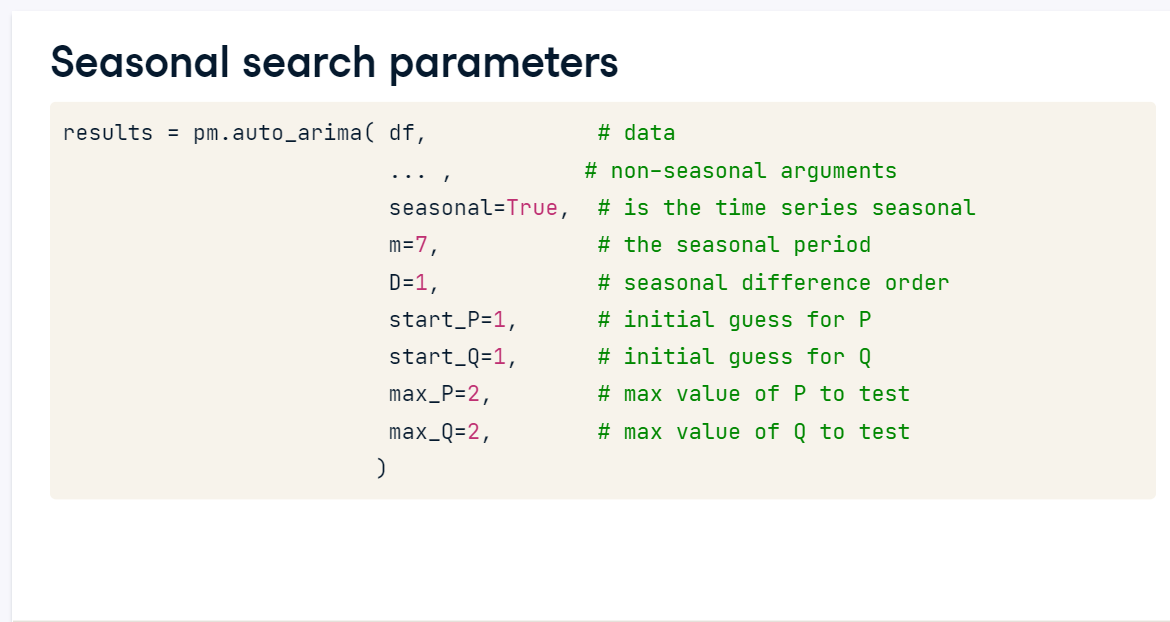

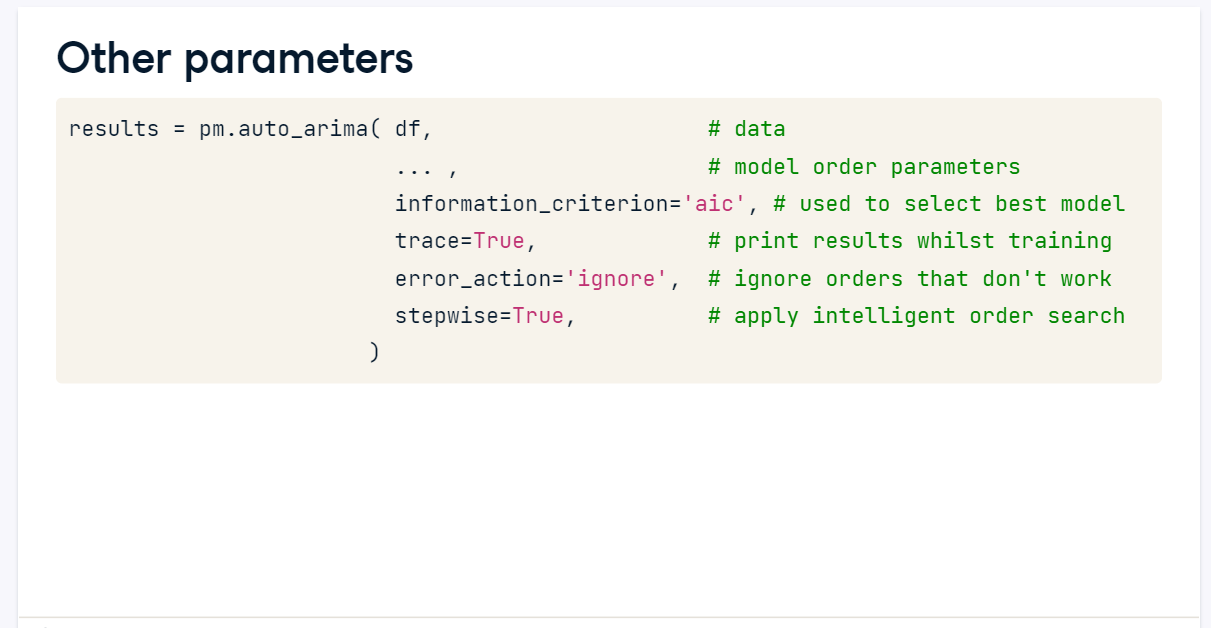

In [495]:
import pmdarima as pm

In [579]:
results = pm.auto_arima(google_log, 
                        information_criterion='aic',
                        trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-6881.065, Time=0.56 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6877.258, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6883.357, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6883.070, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6877.931, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-6881.575, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6881.471, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-6879.609, Time=0.67 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-6883.801, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-6882.060, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-6881.930, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-6883.505, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-6880.097, Time=0.19 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 2.789 seconds


In [580]:
results

ARIMA(order=(1, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [547]:
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1258
Model:               SARIMAX(1, 1, 0)   Log Likelihood                3443.900
Date:                Mon, 26 Feb 2024   AIC                          -6883.801
Time:                        17:42:35   BIC                          -6873.528
Sample:                             0   HQIC                         -6879.940
                               - 1258                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0790      0.018     -4.428      0.000      -0.114      -0.044
sigma2         0.0002   3.78e-06     64.540      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.00   Jarque-

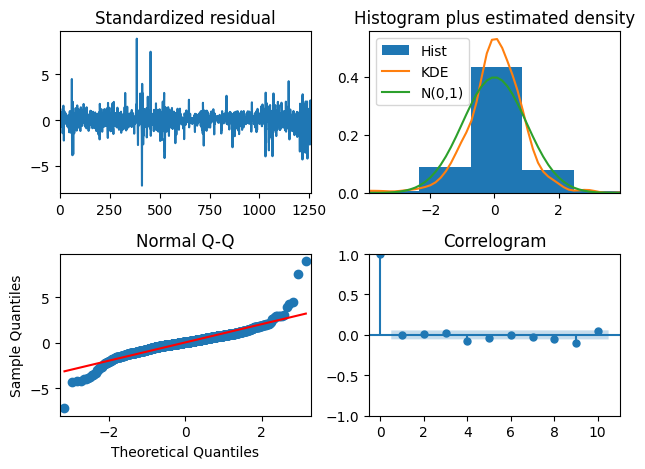

In [553]:
results.plot_diagnostics()
plt.tight_layout()
plt.show()

# Forecasting

## In Sample Forecasting 

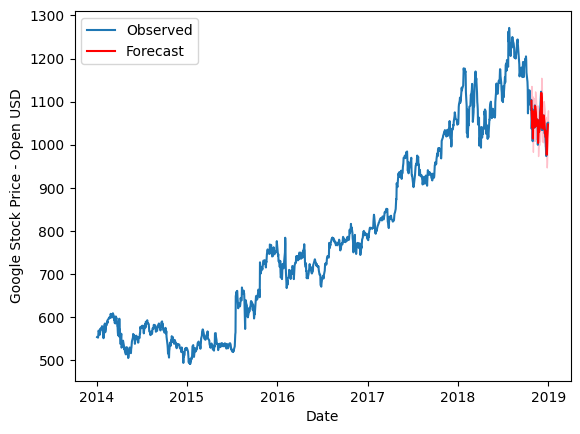

In [617]:
forecast = result.get_prediction(start =-45)
mean_forecast = forecast.predicted_mean

conf_int = forecast.conf_int()


lower_limits = conf_int.loc[:,'lower Open']
upper_limits = conf_int.loc[:,'upper Open']

plt.plot(google.index, google, label = 'Observed')

plt.plot(mean_forecast.index, np.exp(mean_forecast), color = 'red', label = 'Forecast')

plt.fill_between(lower_limits.index, np.exp(lower_limits), np.exp(upper_limits), color = 'pink')

plt.xlabel('Date')
plt.ylabel('Google Stock Price - Open USD')
plt.legend()
plt.show()

## Dynamic Forecasting

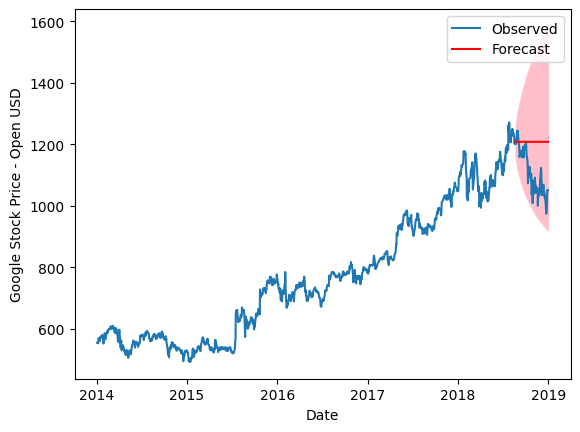

In [605]:
forecast = result.get_prediction(start =-90, dynamic = True)
mean_forecast = forecast.predicted_mean

conf_int = forecast.conf_int()


lower_limits = conf_int.loc[:,'lower Open']
upper_limits = conf_int.loc[:,'upper Open']

plt.plot(google.index, google, label = 'Observed')

plt.plot(mean_forecast.index, np.exp(mean_forecast), color = 'red', label = 'Forecast')

plt.fill_between(lower_limits.index, np.exp(lower_limits), np.exp(upper_limits), color = 'pink')

plt.xlabel('Date')
plt.ylabel('Google Stock Price - Open USD')
plt.legend()
plt.show()

## Out Sample Forecasting 

In [624]:
arima_value_forecasting = results.predict(60)

c:\Users\nickc\DataScience\ds_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

c:\Users\nickc\DataScience\ds_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



In [625]:
np.exp(arima_value_forecasting)

1258    1050.854003
1259    1050.862376
1260    1050.861714
1261    1050.861767
1262    1050.861762
1263    1050.861763
1264    1050.861763
1265    1050.861763
1266    1050.861763
1267    1050.861763
1268    1050.861763
1269    1050.861763
1270    1050.861763
1271    1050.861763
1272    1050.861763
1273    1050.861763
1274    1050.861763
1275    1050.861763
1276    1050.861763
1277    1050.861763
1278    1050.861763
1279    1050.861763
1280    1050.861763
1281    1050.861763
1282    1050.861763
1283    1050.861763
1284    1050.861763
1285    1050.861763
1286    1050.861763
1287    1050.861763
1288    1050.861763
1289    1050.861763
1290    1050.861763
1291    1050.861763
1292    1050.861763
1293    1050.861763
1294    1050.861763
1295    1050.861763
1296    1050.861763
1297    1050.861763
1298    1050.861763
1299    1050.861763
1300    1050.861763
1301    1050.861763
1302    1050.861763
1303    1050.861763
1304    1050.861763
1305    1050.861763
1306    1050.861763
1307    1050.861763


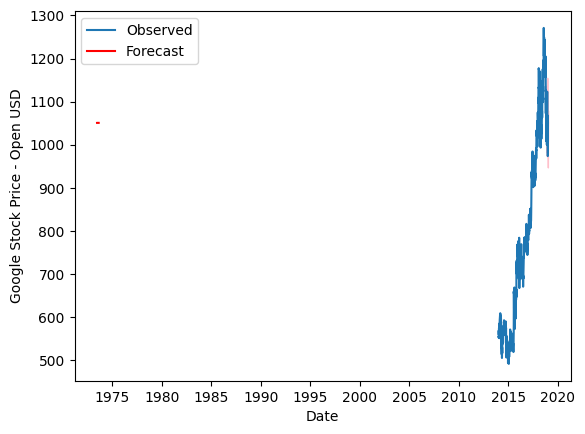

In [626]:
plt.plot(google.index, google, label = 'Observed')

plt.plot(arima_value_forecasting.index, np.exp(arima_value_forecasting), color = 'red', label = 'Forecast')

plt.fill_between(lower_limits.index, np.exp(lower_limits), np.exp(upper_limits), color = 'pink')

plt.xlabel('Date')
plt.ylabel('Google Stock Price - Open USD')
plt.legend()
plt.show()